In [16]:

# --- Setup (one time) ---
# This cell makes the notebook usable by anyone who cloned the repo.
# It installs the local package (`irr`) from the repo root in editable mode,
# and ensures scikit-learn is available for the confusion matrix.

import sys, subprocess, importlib.util, pathlib

def _pip_install(args):
    subprocess.check_call([sys.executable, "-m", "pip"] + args)

# 1) Ensure `irr` is importable
if importlib.util.find_spec("irr") is None:
    # Assume this notebook lives in <repo>/notebooks/
    repo_root = pathlib.Path.cwd().resolve().parent
    print(f"[INFO] Installing local package from: {repo_root}")
    _pip_install(["install", "-e", str(repo_root)])

# 2) Ensure scikit-learn is present (optional, for ROC thresholding)
if importlib.util.find_spec("sklearn") is None:
    print("[INFO] Installing scikit-learn for confusion matrix metrics...")
    _pip_install(["install", "scikit-learn>=1.3,<2"])

print("[INFO] Setup complete. If imports still fail, restart the kernel and re-run.")


[INFO] Setup complete. If imports still fail, restart the kernel and re-run.



# Training Curves & Confusion Matrix (Modular `irr` setup)

This notebook is tailored for the **modular package** layout (`irr/*`). It:
- Detects the **latest** Lightning `CSVLogger` run under `outputs/logs/tiny_head/**` (or a user-set override).
- Plots **epoch-wise** `train_loss`, `val_loss`, `train_auroc`, `val_auroc`, `train_auprc`, `val_auprc`.
- Loads `val_predictions.csv` from the same run directory and computes a **confusion matrix**.
- Chooses a decision threshold via **Youden's J** on the ROC curve (falls back to `0.5` if `sklearn` isn't available).

> Tip: If your logs live elsewhere, set `LOG_DIR` below or use `IRR_LOG_DIR` env var.


In [17]:

import os, sys, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import irr; if it fails, add the project root (folder containing pyproject.toml or .git) to sys.path
def _ensure_project_on_path(markers=("pyproject.toml", ".git")):
    here = Path.cwd()
    for p in [here] + list(here.parents):
        for m in markers:
            if (p / m).exists():
                if str(p) not in sys.path:
                    sys.path.insert(0, str(p))
                return p
    return None

root = _ensure_project_on_path()
if root:
    print(f"[INFO] Added project root to sys.path: {root}")

try:
    import irr
    print("[INFO] irr package:", irr.__file__)
except Exception as e:
    print("[WARN] Could not import irr:", e)
    print("[HINT] If you're using Poetry, select the Poetry venv kernel or run `%pip install -e .` in this notebook.")

# Optional: scikit-learn metrics
try:
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
    SKLEARN_OK = True
except Exception as e:
    print("[WARN] scikit-learn not available; ROC-based thresholding disabled.", e)
    SKLEARN_OK = False


[INFO] Added project root to sys.path: /Users/tim/repos/pytorch_irr_model_modular
[INFO] irr package: /Users/tim/repos/pytorch_irr_model_modular/irr/__init__.py


## 1) Configure log discovery

In [18]:

# Option A: leave LOG_DIR=None to auto-detect the latest run by metrics.csv mtime
LOG_DIR = None  # e.g., Path("outputs/logs/tiny_head/version_3") or an absolute path

# Option B: environment variable override (set IRR_LOG_DIR to a run folder)
import os, glob
from pathlib import Path

env_override = os.environ.get("IRR_LOG_DIR")
if env_override:
    LOG_DIR = Path(env_override).expanduser()

def _find_repo_root(markers=("pyproject.toml", ".git")):
    '''Return repository root by walking up from CWD until a marker is found.'''
    here = Path.cwd().resolve()
    for p in [here] + list(here.parents):
        for m in markers:
            if (p / m).exists():
                return p
    return here  # fallback: current dir

REPO_ROOT = _find_repo_root()
OUTPUTS_ROOT = REPO_ROOT / "outputs"

def find_latest_run():
    candidates = []
    # Prefer canonical tiny_head path
    tiny_root = OUTPUTS_ROOT / "logs" / "tiny_head"
    if tiny_root.exists():
        candidates.extend(Path(p) for p in glob.glob(str(tiny_root / "**/metrics.csv"), recursive=True))
    # Fallback: anywhere under outputs/
    if OUTPUTS_ROOT.exists():
        candidates.extend(Path(p) for p in glob.glob(str(OUTPUTS_ROOT / "**/metrics.csv"), recursive=True))
    # Last resort: search entire repo (can be slow but robust)
    if not candidates:
        candidates.extend(Path(p) for p in glob.glob(str(REPO_ROOT / "**/metrics.csv"), recursive=True))
    if not candidates:
        raise FileNotFoundError(
            f"No metrics.csv found under {OUTPUTS_ROOT}.\n"
            "Run training first or set LOG_DIR to a specific run dir, e.g.:\n"
            "  LOG_DIR = Path('outputs/logs/tiny_head/version_3')  # adjust number\n"
            "or set IRR_LOG_DIR=/absolute/path/to/version_X"
        )
    metrics_path = max(candidates, key=lambda p: p.stat().st_mtime)
    run_dir = metrics_path.parent
    return run_dir, metrics_path

if LOG_DIR is None:
    RUN_DIR, METRICS_CSV = find_latest_run()
else:
    LOG_DIR = Path(LOG_DIR).expanduser().resolve()
    METRICS_CSV = LOG_DIR / "metrics.csv"
    if not METRICS_CSV.exists():
        ms = list(LOG_DIR.glob("**/metrics.csv"))
        if not ms:
            raise FileNotFoundError(f"No metrics.csv found under {LOG_DIR}")
        METRICS_CSV = max(ms, key=lambda p: p.stat().st_mtime)
        LOG_DIR = METRICS_CSV.parent
    RUN_DIR = LOG_DIR

print("[INFO] Repo root:", REPO_ROOT)
print("[INFO] Using run dir:", RUN_DIR)
print("[INFO] Metrics CSV:", METRICS_CSV)


[INFO] Repo root: /Users/tim/repos/pytorch_irr_model_modular
[INFO] Using run dir: /Users/tim/repos/pytorch_irr_model_modular/outputs/logs/tiny_head/version_4
[INFO] Metrics CSV: /Users/tim/repos/pytorch_irr_model_modular/outputs/logs/tiny_head/version_4/metrics.csv


## 2) Load metrics and plot epoch-wise curves

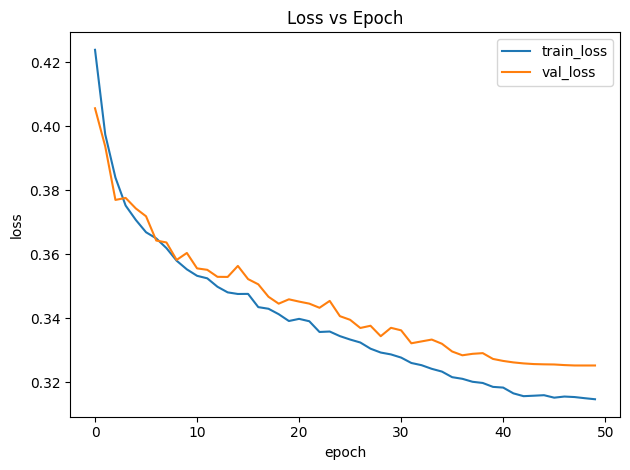

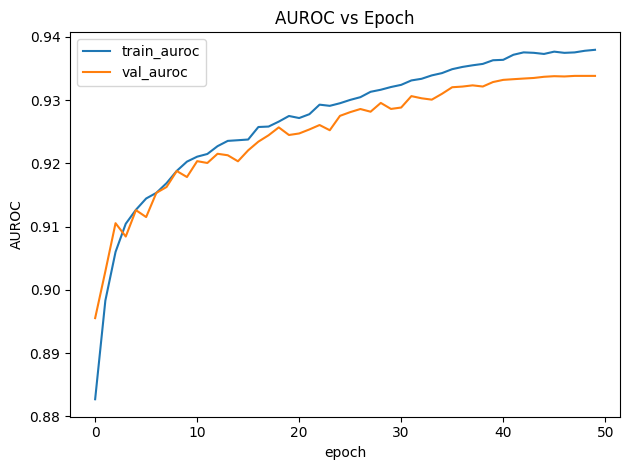

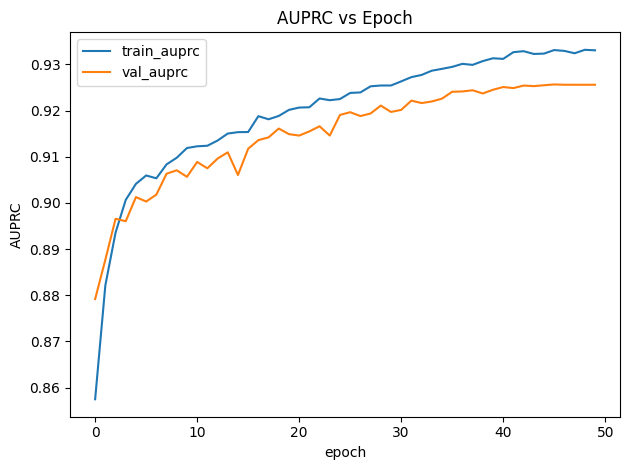


[FINAL EPOCH METRICS]
train_loss: 0.3147
val_loss: 0.3252
train_auroc: 0.9379
val_auroc: 0.9338
train_auprc: 0.9331
val_auprc: 0.9256


In [19]:

df = pd.read_csv(METRICS_CSV)

if "epoch" not in df.columns and "step" in df.columns:
    df["epoch"] = df["step"]
sort_cols = [c for c in ["epoch", "step"] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols).reset_index(drop=True)

def last_per_epoch(frame: pd.DataFrame, col: str):
    if col not in frame.columns:
        return None
    if "epoch" not in frame.columns:
        return frame[col]
    return frame.groupby("epoch", as_index=True)[col].last()

def plot_metric(frame: pd.DataFrame, train_key: str, val_key: str, title: str, ylabel: str):
    train_series = last_per_epoch(frame, train_key) if train_key else None
    val_series   = last_per_epoch(frame, val_key)   if val_key   else None
    if train_series is None and val_series is None:
        print(f"[WARN] Neither {train_key} nor {val_key} found; skipping {title}")
        return
    plt.figure()
    if train_series is not None:
        train_series.plot(label=train_key)
    if val_series is not None:
        val_series.plot(label=val_key)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric(df, "train_loss",  "val_loss",  "Loss vs Epoch",  "loss")
plot_metric(df, "train_auroc", "val_auroc", "AUROC vs Epoch", "AUROC")
plot_metric(df, "train_auprc", "val_auprc", "AUPRC vs Epoch", "AUPRC")

final = {}
for k in ["train_loss","val_loss","train_auroc","val_auroc","train_auprc","val_auprc"]:
    if k in df.columns:
        final[k] = df.groupby("epoch")[k].last().iloc[-1]
if final:
    print("\n[FINAL EPOCH METRICS]")
    for k, v in final.items():
        print(f"{k}: {v:.4f}")


## 3) Confusion matrix from `val_predictions.csv`

[INFO] Using predictions file: /Users/tim/repos/pytorch_irr_model_modular/outputs/logs/tiny_head/version_4/val_predictions.csv
[INFO] Threshold via Youden's J: 0.4826

[CONFUSION MATRIX] (rows=true, cols=pred)
        Pred 0  Pred 1
True 0    4269     731
True 1     688    4312

Accuracy:  0.8581
Precision:  0.8550
Recall:     0.8624
F1-score:   0.8587
Threshold:  0.4826


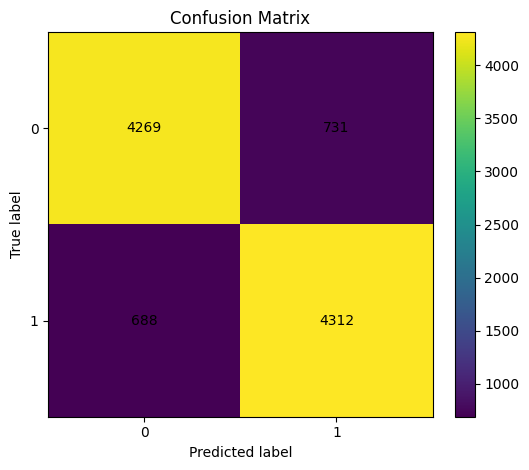

In [20]:

cand_files = list(RUN_DIR.glob("**/val_predictions.csv"))
if not cand_files:
    cand_files = []
    for pat in ["predictions*.csv", "val*pred*.csv", "preds*.csv"]:
        cand_files += list(RUN_DIR.glob(f"**/{pat}"))

if not cand_files:
    print("[INFO] No predictions CSV found in", RUN_DIR)
    print("To enable the confusion matrix, save validation predictions to CSV during validation, e.g.:")
    print("  - Use irr.callbacks.prediction_dump.PredictionDumpCallback, or")
    print("  - In TinyHead, collect probs/targets and write `val_predictions.csv` in on_validation_epoch_end.")
else:
    PRED_CSV = max(cand_files, key=lambda p: p.stat().st_mtime)
    print("[INFO] Using predictions file:", PRED_CSV)
    pdf = pd.read_csv(PRED_CSV)

    y_true_cols = ["y_true", "target", "label", "labels"]
    y_prob_cols = ["y_prob", "prob", "proba", "score", "logit"]
    y_pred_cols = ["y_pred", "pred", "prediction"]

    def pick(cols):
        for c in cols:
            if c in pdf.columns:
                return c
        return None

    y_true_col = pick(y_true_cols)
    y_prob_col = pick(y_prob_cols)
    y_pred_col = pick(y_pred_cols)

    if y_true_col is None:
        raise ValueError(f"Ground-truth column not found; looked for {y_true_cols}")

    y_true = pdf[y_true_col].astype(int).values

    if y_pred_col is not None:
        y_pred = (pdf[y_pred_col].astype(int).values > 0).astype(int)
        threshold = None
        print("[INFO] Using provided binary predictions.")
    elif y_prob_col is not None:
        y_prob = pdf[y_prob_col].astype(float).values
        if SKLEARN_OK:
            fpr, tpr, thr = roc_curve(y_true, y_prob)
            j_scores = tpr - fpr
            j_idx = int(np.argmax(j_scores))
            threshold = float(thr[j_idx])
            print(f"[INFO] Threshold via Youden's J: {threshold:.4f}")
        else:
            threshold = 0.5
            print("[WARN] sklearn unavailable; using default threshold 0.5")
        y_pred = (y_prob >= threshold).astype(int)
    else:
        raise ValueError(f"No probability or binary prediction column found in {PRED_CSV}.")

    if SKLEARN_OK:
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    else:
        tn = int(((y_true == 0) & (y_pred == 0)).sum())
        fp = int(((y_true == 0) & (y_pred == 1)).sum())
        fn = int(((y_true == 1) & (y_pred == 0)).sum())
        tp = int(((y_true == 1) & (y_pred == 1)).sum())
        cm = np.array([[tn, fp],[fn, tp]])

    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / max(cm.sum(), 1)
    prec = tp / max((tp + fp), 1)
    rec = tp / max((tp + fn), 1)
    f1 = (2 * prec * rec) / max((prec + rec), 1e-12)

    print("\n[CONFUSION MATRIX] (rows=true, cols=pred)")
    import pandas as pd
    print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    if 'threshold' in locals() and threshold is not None:
        print(f"Threshold:  {threshold:.4f}")

    import numpy as np
    plt.figure()
    im = plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()



## 4) Enabling predictions in modular setup

**Recommended:** use the `PredictionDumpCallback` under `irr.callbacks` and add it to `Trainer(callbacks=[...])`.
